**Apogee Data Modified VAE Testing**

This file is used to load an existing model and continue training

In [1]:
# Hardware check
!nvidia-smi

Sat Apr  2 13:16:31 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 512.15       Driver Version: 512.15       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:0A:00.0  On |                  N/A |
|  0%   40C    P8    30W / 340W |    536MiB / 10240MiB |     10%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Basic imports
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import datetime

from torch.optim import Adam

from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

from tqdm import tqdm
from torchvision.utils import save_image, make_grid

from astropy.io import fits

from matplotlib import pyplot as plt

In [3]:
# GPU verification
print(torch.cuda.is_available())
print(torch.cuda.current_device())
print(torch.cuda.device(0))
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

True
0
1
NVIDIA GeForce RTX 3080


**Hyperparameters**

In [4]:
# Hyperparameters
dataset_path = '~/datasets'
cuda = True
DEVICE = torch.device("cuda" if cuda else "cpu")

# Data parameters
input_rows = 60000   # Number of spectra to input, tried 20k before. Try 60k now.
batch_size = 500    # Tested 100
validation_split = .2   # Fraction of dataset to reserve for test
random_seed = 42
np.random.seed(random_seed)
shuffle_toggle = False  # Redundant due to random reduced idx already implemented

# Model Dimensions
x_dim  = 7514
# Originally 400, 200
hidden_dim = 400
latent_dim = 28

# Learning rate
# Default 0.001
lr = 0.001
# Gradient clipping
clipping_value = 1

# VAE Beta - used 10000
beta = 1
# VAE Separability Loss scaling factor
# Approx need ~40M - used 100000
gamma = 1

# Num epochs
epochs = 300

**Process and Load Data**

In [5]:
# from google.colab import drive
# drive.mount('/content/drive')

In [6]:
def starInfoDebug():
  for i in range(10):
      # Title information
      print("\n**************** Looking at index ", i, " ****************")
      print("APSTAR ID: ", star['apstar_id'][i],\
          "\nTARGET_ID: ", star['target_id'][i],\
              "\nASPCAP_ID: ", star['aspcap_id'][i])
      
      print("\nBasic Stats:")
      print("SNR: ", star['snr'][i])
      print("Effective Temp (K) \t ASPCAP: ", star['teff_spec'][i], 'AstroNN:', star_astroNN['TEFF'][i])
      print("Surface G (log(cm/s^2) \t ASPCAP: ", star['logg_spec'][i], 'AstroNN:', star_astroNN['LOGG'][i])

      #j = ind[i]
      j = i

      plt.subplot(5, 2, j+1)
      plt.title(star['aspcap_id'][i])
      plt.xlabel('Wavelength')
      plt.ylabel('Relative Flux')
      # 7514 data points for each spectra
      plt.plot(star_spectra[j])

      spectra_df = pd.DataFrame(star_spectra[j])
      # Actual input data
      print("\nInput dataframe:")
      print(spectra_df)

      #print(len(star_spectra[j]))
      #plt.legend([star['aspcap_id'][i]])
      #plt.show()

      # Abundances, other info
      print("\nAbundances, additional info (ASPCAP):")
      print(star['ra'][j], star['dec'][j], star['glon'][j], star['glat'][j],\
          star['vhelio_avg'][j], star['vscatter'][j],\
          star['teff'][j], star['teff_err'][j],\
          star['logg'][j], star['logg_err'][j],\
          star['m_h'][j], star['m_h_err'][j],\
          star['alpha_m'][j], star['alpha_m_err'][j],\
          star['c_fe'][j], star['c_fe_err'][j],\
          star['cI_fe'][j], star['cI_fe_err'][j],\
          star['n_fe'][j], star['n_fe_err'][j],\
          star['o_fe'][j], star['o_fe_err'][j],\
          star['na_fe'][j], star['na_fe_err'][j],\
          star['mg_fe'][j], star['mg_fe_err'][j],\
          star['al_fe'][j], star['al_fe_err'][j],\
          star['si_fe'][j], star['si_fe_err'][j],\
          star['p_fe'][j], star['p_fe_err'][j],\
          star['s_fe'][j], star['s_fe_err'][j],\
          star['k_fe'][j], star['k_fe_err'][j],\
          star['ca_fe'][j], star['ca_fe_err'][j],\
          star['ti_fe'][j], star['ti_fe_err'][j],\
          star['v_fe'][j], star['v_fe_err'][j],\
          star['cr_fe'][j], star['cr_fe_err'][j],\
          star['mn_fe'][j], star['mn_fe_err'][j],\
          star['fe_h'][j], star['fe_h_err'][j],\
          star['co_fe'][j], star['co_fe_err'][j],\
          star['ni_fe'][j], star['ni_fe_err'][j],\
          star['cu_fe'][j], star['cu_fe_err'][j],\
          star['ge_fe'][j], star['ge_fe_err'][j],\
          star['rb_fe'][j], star['rb_fe_err'][j],\
          star['aspcapflags'][j], star['starflags'][j])

      plt.subplots_adjust(hspace=1)
      #plt.tight_layout()
      plt.show()

In [7]:
print("\n ********************** Opening FITS files from drive **********************")

star_hdus = fits.open('allStar-r12-l33.fits')
astroNN_hdus = fits.open('apogee_astroNN-DR16-v1.fits')
star_spec = fits.open('contspec_dr16_final.fits')

star = star_hdus[1].data
star_astroNN = astroNN_hdus[1].data
star_spectra = star_spec[0].data

star_hdus.close()
astroNN_hdus.close()
star_spec.close()

print("Number of spectra: ", len(star))
print("Data points per spectra: ", len(star_spectra[1]))

# starInfoDebug()


 ********************** Opening FITS files from drive **********************
Number of spectra:  473307
Data points per spectra:  7514


**Load errors, good flags**

Restrict errors to no smaller than 1/200

In [8]:
star_mask = fits.open('contspec_dr16_mask.fits')
star_err = fits.open('contspec_dr16_err.fits')

star_mask_data = star_mask[0].data
star_err_data = star_err[0].data

# Clipping only performed for floor
star_err_data = np.clip(star_err_data, 0.005, None)

star_mask.close()
star_err.close()

print("Number of masks: ", len(star_mask_data))
print("Data points per maskk: ", len(star_mask_data[1]))

print("Number of errors: ", len(star_err_data))
print("Data points per error: ", len(star_err_data[1]))

Number of masks:  473307
Data points per maskk:  7514
Number of errors:  473307
Data points per error:  7514


**Data cuts, slices**

We only include stars with no bad star flags set, SNR > 200, 4000 < teff < 5500, and logg < 3.5.

In [9]:
# Further Star Analysis
from astropy.table import Table
dat = Table.read('allStar-r12-l33.fits', format='fits')
names = [name for name in dat.colnames if len(dat[name].shape) <= 1]
df = dat[names].to_pandas()
df.head()

,APSTAR_ID,TARGET_ID,ASPCAP_ID,FILE,APOGEE_ID,TELESCOPE,LOCATION_ID,FIELD,J,J_ERR,...,GAIA_PHOT_G_MEAN_MAG,GAIA_PHOT_BP_MEAN_MAG,GAIA_PHOT_RP_MEAN_MAG,GAIA_RADIAL_VELOCITY,GAIA_RADIAL_VELOCITY_ERROR,GAIA_R_EST,GAIA_R_LO,GAIA_R_HI,TEFF_SPEC,LOGG_SPEC
0,b'apogee.apo1m.s.stars.calibration.VESTA',b'apo1m.1.calibration.VESTA',b'apogee.apo1m.s.r12-l33.calibration.VESTA',b'apStar-r12-VESTA.fits',b'VESTA',b'apo1m',1,b'calibration',-9999.990234,-9999.990234,...,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,5770.700195,4.49400
1,b'apogee.apo25m.s.stars.120+12.2M00000002+7417...,b'apo25m.5046.120+12.2M00000002+7417074',b'apogee.apo25m.s.r12-l33.120+12.2M00000002+74...,b'apStar-r12-2M00000002+7417074.fits',b'2M00000002+7417074',b'apo25m',5046,b'120+12',8.597000,0.039000,...,11.709962,13.291449,10.511990,-51.924661,0.365646,3285.226548,2959.076000,3687.594547,3628.600098,0.88758
2,b'apogee.apo25m.s.stars.060-75.2M00000019-1924...,b'apo25m.5071.060-75.2M00000019-1924498',b'apogee.apo25m.s.r12-l33.060-75.2M00000019-19...,b'apStar-r12-2M00000019-1924498.fits',b'2M00000019-1924498',b'apo25m',5071,b'060-75',11.074000,0.022000,...,12.187422,12.534893,11.669607,17.880444,2.120882,191.348325,156.570781,245.761634,5527.700195,4.23810
3,b'apogee.apo25m.s.stars.116-04.2M00000032+5737...,b'apo25m.4424.116-04.2M00000032+5737103',b'apogee.apo25m.s.r12-l33.116-04.2M00000032+57...,b'apStar-r12-2M00000032+5737103.fits',b'2M00000032+5737103',b'apo25m',4424,b'116-04',10.905000,0.023000,...,12.230203,12.671972,11.631516,-19.196012,1.356420,801.567552,780.757419,823.495963,6449.200195,4.01460
4,b'apogee.apo25m.s.stars.N7789.2M00000032+5737103',b'apo25m.4264.N7789.2M00000032+5737103',b'apogee.apo25m.s.r12-l33.N7789.2M00000032+573...,b'apStar-r12-2M00000032+5737103.fits',b'2M00000032+5737103',b'apo25m',4264,b'N7789',10.905000,0.023000,...,12.230203,12.671972,11.631516,-19.196012,1.356420,801.567552,780.757419,823.495963,6411.600098,3.97610


In [10]:
# Isolate critical columns
star_df = df[['APSTAR_ID', 'TEFF_SPEC', 'LOGG_SPEC', 'SNR', 'ASPCAPFLAGS', 'STARFLAGS', 'FE_H']]
star_df

,APSTAR_ID,TEFF_SPEC,LOGG_SPEC,SNR,ASPCAPFLAGS,STARFLAGS,FE_H
0,b'apogee.apo1m.s.stars.calibration.VESTA',5770.700195,4.49400,405.761993,b'',b'',-0.001886
1,b'apogee.apo25m.s.stars.120+12.2M00000002+7417...,3628.600098,0.88758,841.507019,b'',"b'PERSIST_MED,PERSIST_LOW'",-0.165732
2,b'apogee.apo25m.s.stars.060-75.2M00000019-1924...,5527.700195,4.23810,188.955994,b'',b'',-0.285279
3,b'apogee.apo25m.s.stars.116-04.2M00000032+5737...,6449.200195,4.01460,120.471001,b'',"b'PERSIST_HIGH,SUSPECT_BROAD_LINES'",-0.168239
4,b'apogee.apo25m.s.stars.N7789.2M00000032+5737103',6411.600098,3.97610,215.662994,b'',b'SUSPECT_BROAD_LINES',-0.178222
...,...,...,...,...,...,...,...
473302,b'apogee.apo25m.s.stars.N188.2M23595756+8535275',5018.799805,4.48350,376.756012,b'',b'BRIGHT_NEIGHBOR',0.225131
473303,b'apogee.apo25m.s.stars.N7789.2M23595837+5700444',4927.500000,2.77310,91.416901,b'',b'',-0.309132
473304,b'apogee.apo25m.s.stars.060-75.2M23595886-2009...,5456.799805,4.20270,112.213997,b'',b'',0.071140
473305,b'apogee.apo25m.s.stars.116-04.2M23595886+5726...,4806.399902,2.78250,202.197998,b'',"b'PERSIST_MED,PERSIST_LOW'",-0.224732


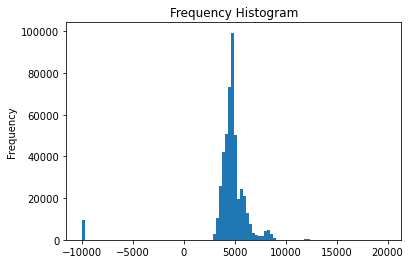

In [11]:
star_snr = star_df[["TEFF_SPEC"]]
plt.hist(star_snr, bins=100)
plt.gca().set(title='Frequency Histogram', ylabel='Frequency');

In [12]:
#We only include stars with no bad star flags set, SNR > 200, 4000 < teff < 5500, and logg < 3.5, FE_H > -4
star_df_best = star_df.loc[(star_df['TEFF_SPEC'] < 5500) & (star_df['TEFF_SPEC'] > 4000) & (star_df['LOGG_SPEC'] < 3.5) & (star_df['LOGG_SPEC'] > 0) & (star_df['SNR'] > 200) & (star_df['FE_H'] > -4)]
star_df_best

,APSTAR_ID,TEFF_SPEC,LOGG_SPEC,SNR,ASPCAPFLAGS,STARFLAGS,FE_H
18,b'apogee.apo25m.s.stars.120+08.2M00000866+7122...,4607.000000,2.7701,454.351990,b'',b'',-0.108232
23,b'apogee.apo25m.s.stars.116+00.2M00001199+6114...,4611.000000,2.6715,343.740997,b'',b'',0.060205
28,b'apogee.apo25m.s.stars.N7789.2M00001328+5725563',4447.200195,2.4789,232.462997,b'',b'',0.034211
34,b'apogee.apo25m.s.stars.N7789.2M00001653+5540107',4040.199951,1.7878,235.604004,b'',b'',-0.173762
37,b'apogee.apo25m.s.stars.116+00.2M00001717+6147...,4677.000000,2.5777,205.179001,b'',b'PERSIST_LOW',-0.299762
...,...,...,...,...,...,...,...
473289,b'apogee.apo25m.s.stars.120+12.2M23595481+7509...,4742.500000,2.8883,467.380005,b'',b'',-0.389182
473290,b'apogee.apo25m.s.stars.N7789.2M23595490+5704387',5017.799805,3.2260,606.460999,b'',b'',0.070190
473298,b'apogee.apo25m.s.stars.116+00.2M23595606+6251...,4198.600098,2.0426,314.253998,b'',b'',-0.081533
473301,b'apogee.apo25m.s.stars.120+18.2M23595676+7918...,4171.299805,1.9010,443.684998,b'',b'',-0.475612


Unique ASPCAP Flags

In [13]:
flagList = star_df_best['ASPCAPFLAGS'].unique()
for flag in flagList:
    print(flag.decode())


STAR_WARN,COLORTE_WARN
STAR_WARN,ROTATION_WARN
STAR_WARN,COLORTE_WARN,ROTATION_WARN
STAR_WARN,CHI2_WARN


In [14]:
# Decode byte flags into strings
star_df_best['ASPCAPFLAGS'] = star_df_best['ASPCAPFLAGS'].str.decode("utf-8")

<ipython-input-14-e4f9950277f7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  star_df_best['ASPCAPFLAGS'] = star_df_best['ASPCAPFLAGS'].str.decode("utf-8")


In [15]:
# Strip out stars with STAR_BAD flag
star_df_best = star_df_best.loc[~(star_df_best['ASPCAPFLAGS'].str.contains("STAR_BAD"))]
star_df_best

,APSTAR_ID,TEFF_SPEC,LOGG_SPEC,SNR,ASPCAPFLAGS,STARFLAGS,FE_H
18,b'apogee.apo25m.s.stars.120+08.2M00000866+7122...,4607.000000,2.7701,454.351990,,b'',-0.108232
23,b'apogee.apo25m.s.stars.116+00.2M00001199+6114...,4611.000000,2.6715,343.740997,,b'',0.060205
28,b'apogee.apo25m.s.stars.N7789.2M00001328+5725563',4447.200195,2.4789,232.462997,,b'',0.034211
34,b'apogee.apo25m.s.stars.N7789.2M00001653+5540107',4040.199951,1.7878,235.604004,,b'',-0.173762
37,b'apogee.apo25m.s.stars.116+00.2M00001717+6147...,4677.000000,2.5777,205.179001,,b'PERSIST_LOW',-0.299762
...,...,...,...,...,...,...,...
473289,b'apogee.apo25m.s.stars.120+12.2M23595481+7509...,4742.500000,2.8883,467.380005,,b'',-0.389182
473290,b'apogee.apo25m.s.stars.N7789.2M23595490+5704387',5017.799805,3.2260,606.460999,,b'',0.070190
473298,b'apogee.apo25m.s.stars.116+00.2M23595606+6251...,4198.600098,2.0426,314.253998,,b'',-0.081533
473301,b'apogee.apo25m.s.stars.120+18.2M23595676+7918...,4171.299805,1.9010,443.684998,,b'',-0.475612


Update the spectra dataframe with only 'good' indices

*February 16 2022 Update: Append Teff, Logg, Fe/H to each spectra*

In [16]:
# Extract columns with three target parameters
star_df_best_parameters = star_df_best[["TEFF_SPEC", "LOGG_SPEC", "FE_H"]]
star_df_best_parameters.reset_index()
star_df_best_parameters

,TEFF_SPEC,LOGG_SPEC,FE_H
18,4607.000000,2.7701,-0.108232
23,4611.000000,2.6715,0.060205
28,4447.200195,2.4789,0.034211
34,4040.199951,1.7878,-0.173762
37,4677.000000,2.5777,-0.299762
...,...,...,...
473289,4742.500000,2.8883,-0.389182
473290,5017.799805,3.2260,0.070190
473298,4198.600098,2.0426,-0.081533
473301,4171.299805,1.9010,-0.475612


In [17]:
np.sum(~np.isfinite(star_df_best_parameters))

TEFF_SPEC    0
LOGG_SPEC    0
FE_H         0
dtype: int64

*Errors for added parameters (Teff, Logg, Fe_H)*

In [18]:
# Make a new array with the associated errors for TEFF, LOGG, FE_H
# Have to transform 1d numpy array to 2d array for hstack. Transpose to get row -> Column
parameter_errors = np.hstack((star['teff_err'][None, :].T,star['logg_err'][None, :].T, star['fe_h_err'][None, :].T))
parameter_errors.shape

(473307, 3)

In [19]:
np.max(parameter_errors, axis=0)

array([6.5670636e+02, 2.2734775e-01, 1.9204114e-01], dtype=float32)

In [20]:
star_df_best_parameters_np = star_df_best_parameters.to_numpy()
star_df_best_parameters_np

array([[ 4.6070000e+03,  2.7701001e+00, -1.0823155e-01],
       [ 4.6110000e+03,  2.6715000e+00,  6.0205452e-02],
       [ 4.4472002e+03,  2.4789000e+00,  3.4211453e-02],
       ...,
       [ 4.1986001e+03,  2.0425999e+00, -8.1532545e-02],
       [ 4.1712998e+03,  1.9010000e+00, -4.7561154e-01],
       [ 4.8063999e+03,  2.7825000e+00, -2.2473155e-01]], dtype=float32)

*Normalize the parameter array*

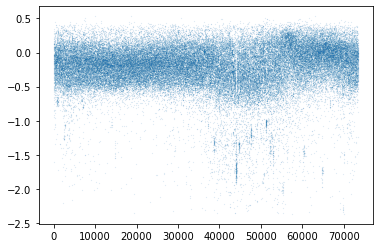

In [21]:
plt.plot(star_df_best_parameters_np[:, -1], '.', ms=0.1)

In [22]:
star_df_best_parameters_np_std_dev = star_df_best_parameters_np.std(axis=0)
star_df_best_parameters_np -= star_df_best_parameters_np.mean(axis=0)
star_df_best_parameters_np /= star_df_best_parameters_np.std(axis=0)

In [23]:
star_df_best_parameters_np[0][-3:]

array([0.11978  , 0.4059073, 0.2948005], dtype=float32)

In [24]:
# Update the star_spectra dataframe with only 'good' indices
star_spectra = star_spectra[star_df_best.index]

In [25]:
# Add teff, logg and fe_h columns to the star spectra
star_spectra = np.hstack((star_spectra, star_df_best_parameters_np))
star_spectra.shape

(73492, 7517)

In [26]:
star_spectra[0]

array([0.91831774, 0.9210329 , 0.9449117 , ..., 0.11978   , 0.4059073 ,
       0.2948005 ], dtype=float32)

In [27]:
star_df_best_parameters_np.shape

(73492, 3)

In [28]:
# Total number of viable spectra
print(len(star_spectra))
# Width of one spectra
print(len(star_spectra[0]))

73492
7517


In [29]:
# Update masks, errors as well
star_err_data = star_err_data[star_df_best.index]
star_mask_data = star_mask_data[star_df_best.index]
parameter_errors = parameter_errors[star_df_best.index]

# Divide parameter errors by std dev of data
parameter_errors /= star_df_best_parameters_np_std_dev

**Dataset Class for Spectral data**

In [30]:
# https://visualstudiomagazine.com/articles/2020/09/10/pytorch-dataloader.aspx

class spectraDataset(torch.utils.data.Dataset):

  # Num rows = max number of spectra to load
  def __init__(self, src, num_rows=None):
    if num_rows == None:
      spectra = src.astype(np.float32)
    else:
      spectra = src.astype(np.float32)[0:num_rows]

    # y_tmp = np.loadtxt(src_file, max_rows=num_rows,
    #   usecols=7, delimiter="\t", skiprows=0,
    #   dtype=np.long)

    self.x_data = torch.tensor(spectra, dtype=torch.float32).to(DEVICE)

    # self.y_data = T.tensor(y_tmp,
    #   dtype=T.long).to(DEVICE)

  def __len__(self):
    return len(self.x_data)  # required

  def __getitem__(self, idx):
    # if T.is_tensor(idx):
    #   idx = idx.tolist()
    # preds = self.x_data[idx, 0:7]
    # pol = self.y_data[idx]
    # sample = \
    #   { 'predictors' : preds, 'political' : pol }

    sample = self.x_data[idx]
    return sample

**Reduction & Train/Test Split**

In [31]:
# # Reduce the dataset down to a manageable size, based on input_rows hyperparameter
np.random.seed(random_seed)
random_reduced_idx = list(np.random.choice(len(star_spectra), input_rows, replace=False))

# # Grab only spectra with indices randomly selected from above
#reduced_star_spectra = np.take(star_spectra, random_reduced_idx, 0)
# reduced_star_spectra = star_spectra[random_reduced_idx]
# # Reduce star mask data
# reduced_star_mask_data = star_mask_data[random_reduced_idx]
# reduced_star_err_data = star_err_data[random_reduced_idx]
#print(pd.DataFrame(reduced_star_spectra))

reduced_star_spectra = star_spectra[0:input_rows]
# Reduce star mask data, errors
reduced_star_mask_data = star_mask_data[0:input_rows]
reduced_star_err_data = star_err_data[0:input_rows]
reduced_parameter_errors = parameter_errors[0:input_rows]

# Normalize - updated to exclude last 3 columns
for starRow in reduced_star_spectra:
    starRow[0:x_dim] -= starRow[0:x_dim].min()
    #print(starRow.max())
    if starRow[0:x_dim].max() == 0:
        print("Found zero max")
    else:
        starRow[0:x_dim] /= starRow[0:x_dim].max()


print(pd.DataFrame(reduced_star_spectra))

print(pd.DataFrame(reduced_star_mask_data))

print(pd.DataFrame(reduced_star_err_data))

print(pd.DataFrame(reduced_parameter_errors))

Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero

In [32]:
print(random_reduced_idx[0:10])

[5860, 28689, 31215, 24765, 2493, 46450, 31123, 23025, 30640, 62582]


In [33]:
print(star_spectra[0])
print(reduced_star_spectra[0])

[0.6782484 0.6827507 0.7223464 ... 0.11978   0.4059073 0.2948005]
[0.6782484 0.6827507 0.7223464 ... 0.11978   0.4059073 0.2948005]


In [34]:
#Normalize (between 0 and 1)

# sum_of_rows = reduced_star_spectra.sum(axis=1)
# reduced_star_spectra = reduced_star_spectra / sum_of_rows[:, np.newaxis]

# reduced_maximum = np.amax(reduced_star_spectra)
# print(reduced_maximum)
# reduced_star_spectra = reduced_star_spectra/reduced_maximum

# Normalization array
# reduced_maximum = np.zeros(len(reduced_star_spectra))

# for i in range(0, len(reduced_star_spectra)):
#   reduced_maximum[i] = np.amax(reduced_star_spectra[i])
#   reduced_star_spectra[i] = reduced_star_spectra[i]/reduced_maximum[i]

# print(pd.DataFrame(reduced_star_spectra))

In [35]:
# Final normalized, reduced inputs
train_dataset = spectraDataset(reduced_star_spectra)
train_dataset[0]

tensor([0.6782, 0.6828, 0.7223,  ..., 0.1198, 0.4059, 0.2948], device='cuda:0')

In [36]:
# Creating data indices for training and validation splits:
dataset_size = len(reduced_star_spectra)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))

print("Splitting dataset at", split)

# If shuffling is enabled, use random seed to shuffle data indices
if shuffle_toggle:
    np.random.seed(random_seed)
    np.random.shuffle(indices)

# Get training/validation indices
train_indices, test_indices = indices[split:], indices[:split]

# Generate random samplers
train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)

Splitting dataset at 12000


In [37]:
print(train_dataset[4000])

tensor([ 0.6471,  0.6870,  0.7481,  ..., -0.9841, -0.5543, -0.2385],
       device='cuda:0')


In [38]:
# Generate data loaders
kwargs = {'num_workers': 0}
#kwargs = {'num_workers': 0} 

# train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, **kwargs)
# test_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=test_sampler, **kwargs)

# Try without random sampling (simple split on index)
train_loader = DataLoader(train_dataset[split:], batch_size=batch_size, **kwargs, shuffle=True)
test_loader = DataLoader(train_dataset[:split], batch_size=batch_size, **kwargs, shuffle=True)

print('Batches in train:', len(train_loader))
print('Batches in test:', len(test_loader))

Batches in train: 96
Batches in test: 24


In [39]:
for idx, train in enumerate(train_loader):
    print(train.shape)
    print(train[0])

torch.Size([500, 7517])
tensor([0.8454, 0.8577, 0.8954,  ..., 0.1512, 1.2392, 0.8252], device='cuda:0')
torch.Size([500, 7517])
tensor([0.8631, 0.8474, 0.8712,  ..., 0.5805, 0.5399, 0.7544], device='cuda:0')
torch.Size([500, 7517])
tensor([ 0.5651,  0.6632,  0.7537,  ..., -1.6829, -1.4057, -0.7354],
       device='cuda:0')
torch.Size([500, 7517])
tensor([0.5847, 0.5804, 0.6036,  ..., 0.4825, 0.9104, 0.7742], device='cuda:0')
torch.Size([500, 7517])
tensor([ 0.9056,  0.9097,  0.9211,  ...,  0.7992,  0.3243, -1.0148],
       device='cuda:0')
torch.Size([500, 7517])
tensor([ 0.5377,  0.5915,  0.6996,  ..., -1.7361, -1.3027,  0.9066],
       device='cuda:0')
torch.Size([500, 7517])
tensor([ 0.7936,  0.7964,  0.8169,  ...,  1.3465,  1.2843, -0.2920],
       device='cuda:0')
torch.Size([500, 7517])
tensor([0.6152, 0.6197, 0.6515,  ..., 0.4345, 0.7512, 0.5455], device='cuda:0')
torch.Size([500, 7517])
tensor([0.9245, 0.9146, 0.9216,  ..., 1.7289, 0.9954, 0.2360], device='cuda:0')
torch.Size([

In [40]:
# MNIST Testing data

# mnist_transform = transforms.Compose([
#         transforms.ToTensor(),
# ])

# kwargs = {'num_workers': 1, 'pin_memory': True} 

# train_dataset = MNIST(dataset_path, transform=mnist_transform, train=True, download=True)
# test_dataset  = MNIST(dataset_path, transform=mnist_transform, train=False, download=True)

# train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
# test_loader  = DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=False, **kwargs)

**Encoder / Decoder / Model**

In [41]:
"""
    A simple implementation of Gaussian MLP Encoder and Decoder
"""

class Encoder(nn.Module):
  def __init__(self, input_dim, hidden_dim, latent_dim):
    super(Encoder, self).__init__()

    # FC Linear version
    self.FC_input = nn.Linear(input_dim+3, 3757)
    # Try batch normalization
    # nn.BatchNorm1d(hidden_dim)
    self.FC_input2 = nn.Linear(3757, 1878)
    self.FC_input3 = nn.Linear(1878, 939)
    self.FC_input4 = nn.Linear(939, 469)
    self.FC_input5 = nn.Linear(469, 234)
    self.FC_input6 = nn.Linear(234, 117)
    self.FC_input7 = nn.Linear(117, 58)
    # self.FC_input8 = nn.Linear(58, 29)

    # Increase number of layers!!

    # Mean and log variance
    self.FC_mean  = nn.Linear(58, latent_dim)
    self.FC_var   = nn.Linear(58, latent_dim)
    
    self.LeakyReLU = nn.LeakyReLU()
    self.gelu = torch.nn.GELU()
    
    self.training = True
      
  def forward(self, x):
    h_ = self.gelu(self.FC_input(x))
    h_ = self.gelu(self.FC_input2(h_))
    h_ = self.gelu(self.FC_input3(h_))
    h_ = self.gelu(self.FC_input4(h_))
    h_ = self.gelu(self.FC_input5(h_))
    h_ = self.gelu(self.FC_input6(h_))
    h_ = self.gelu(self.FC_input7(h_))
    # h_ = self.LeakyReLU(self.FC_input8(h_))

    mean = self.FC_mean(h_)
    log_var = self.FC_var(h_)                     # encoder produces mean and log of variance 
                                                  #             (i.e., parameters of simple tractable normal distribution "q"

    # Last 3 columns of x should be TEFF, LOGG, FE_H
    passed_parameters = x[:, -3:]
    
    return mean, log_var, passed_parameters

In [42]:
class Decoder(nn.Module):
  def __init__(self, latent_dim, hidden_dim, output_dim):
    super(Decoder, self).__init__()

    # FC Linear version
    # self.FC_hidden = nn.Linear(latent_dim, 29)
    self.FC_hidden2 = nn.Linear(latent_dim+3, 58)
    self.FC_hidden3 = nn.Linear(58, 117)
    self.FC_hidden4 = nn.Linear(117, 234)
    self.FC_hidden5 = nn.Linear(234, 469)
    self.FC_hidden6 = nn.Linear(469, 939)
    self.FC_hidden7 = nn.Linear(939, 1878)
    self.FC_hidden8 = nn.Linear(1878, 3757)
    self.FC_output = nn.Linear(3757, output_dim)
    
    self.LeakyReLU = nn.LeakyReLU()
    self.gelu = torch.nn.GELU()

  def forward(self, x):
    # h = self.LeakyReLU(self.FC_hidden(x))
    h = self.gelu(self.FC_hidden2(x))
    h = self.gelu(self.FC_hidden3(h))
    h = self.gelu(self.FC_hidden4(h))
    h = self.gelu(self.FC_hidden5(h))
    h = self.gelu(self.FC_hidden6(h))
    h = self.gelu(self.FC_hidden7(h))
    h = self.gelu(self.FC_hidden8(h))
  
    # originally torch.sigmoid, but output range incorrect
    # Replace with smooth function - look into this!!
    # Softplus, gelu 

    #activation = torch.nn.Softplus()
    activation = torch.nn.GELU()
    x_hat = activation(self.FC_output(h))
    #x_hat = torch.nn.GELU(self.FC_output(h))
    #print(x_hat)
    return x_hat

In [43]:
class Model(nn.Module):
  def __init__(self, Encoder, Decoder):
    # Pass original batch index to model
    super(Model, self).__init__()
    self.Encoder = Encoder
    self.Decoder = Decoder

  def reparameterization(self, mean, var):
    epsilon = torch.randn_like(var).to(DEVICE)        # sampling epsilon        
    z = mean + var*epsilon                          # reparameterization trick
    return z
              
  def forward(self, x, originalIndex, batch_size):
    # Generate mean, log var
    # print("This is x:",x)
    # print(len(x))
    # print(len(x[0]))

    mean, log_var, passed_parameters = self.Encoder(x)
    # print("Passed parameters:\n",passed_parameters)
    #print("Passed parameters shape:\n",passed_parameters.shape)

    z = self.reparameterization(mean, torch.exp(0.5 * log_var)) # takes exponential function (log var -> var)

    # Grab the errors for teff, logg, fe_h
    passed_parameters_errors = torch.from_numpy(reduced_parameter_errors[originalIndex : originalIndex + batch_size].astype(np.float32)).to(DEVICE)
    #print("Passed parameters errors shape:\n",passed_parameters_errors.shape)

    # !! Some fe_h errors have negative values! Need to correct - set all negative errors to zero !
    # print("fe_h:\n",passed_parameters_errors[:,2])
    # print("min fe_h:\n",torch.min(passed_parameters_errors[:,2]))
    passed_parameters_errors = torch.nn.functional.relu(passed_parameters_errors)

    # Sample normal distribution of passed parameters, given mean and error
    # Change from 1d to 2d, then transpose to get column tensor

    # Use our own reparam function to achieve this
    # teff_sampled = torch.normal(mean=passed_parameters[:, 0],std=passed_parameters_errors[:,0])[None, :].T
    # logg_sampled = torch.normal(mean=passed_parameters[:, 1],std=passed_parameters_errors[:,1])[None, :].T
    # fe_h_sampled = torch.normal(mean=passed_parameters[:, 2],std=passed_parameters_errors[:,2])[None, :].T

    # NOTE!!! Take out all sampling if this still doesn't work, after normalization is applied
    u = self.reparameterization(passed_parameters, passed_parameters_errors)

    if True in torch.isnan(u):
      print("!!!!!!!!Found a nan in u!")
      print("Dumping u:\n",u)

    # print("Normal-sampled fe_h:\n",fe_h_sampled)
    # print("Normal-sampled fe_h shape:\n",fe_h_sampled.shape)

    # sampled_parameters = torch.hstack((teff_sampled, logg_sampled, fe_h_sampled))

    #print("Sampled parameters:\n",sampled_parameters)
    #print("Sampled parameters shape:\n",sampled_parameters.shape)

    # if 0 in passed_parameters_sampled:
    #   print("!!!!!!!!Found a zero in sampled parameters (before stack with z)!")

    # Concatenate additional 3 parameters onto z
    z = torch.hstack((z, u))

    # if 0 in z:
    #   print("!!!!!!!!Found a zero in z!")

    if True in torch.isnan(z):
      print("!!!!!!!!Found a nan in z!")
      print("Dumping z:\n",z)

    # print("This is z (with parameters):",z)
    # print(len(z))
    # print(len(z[0]))
    
    x_hat = self.Decoder(z)

    # print("This is x_hat!:",x_hat)
    
    return x_hat, mean, log_var, z

In [44]:
encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim)

model = Model(Encoder=encoder, Decoder=decoder).to(DEVICE)

**Pixel bitmask**

https://arxiv.org/pdf/1706.00009.pdf

https://www.sdss.org/dr14/algorithms/bitmasks/


0 Pixel marked as bad according to bad pixel mask

1 Pixel struck by cosmic ray

2 Pixel saturated

3 Pixel marked as unfixable

4 Pixel marked as bad according to dark frame

5 Pixel marked as bad according to flat frame

6 Pixel set to have a very high error

7 No sky available for this pixel from sky fibers

12 Pixel falls near sky line

In [45]:
def bitmask_boolean(bitmask, target_bit):
    """
    Turn bitmask to boolean with provided bitmask array and target bit to mask

    :param bitmask: bitmask
    :type bitmask: ndarray
    :param target_bit: target bit to mask
    :type target_bit: list[int]
    :return: boolean array, True for clean, False for masked
    :rtype: ndarray[bool]
    :History: 2018-Feb-03 - Written - Henry Leung (University of Toronto)
    """
    target_bit = np.array(target_bit)
    target_bit = np.sum(2 ** target_bit)
    bitmask = np.atleast_2d(bitmask)

    # Modified dtype = bool to dtype = int to get 1s or 0s
    # 0 = has a bad bit, 1 = good
    boolean_output = np.ones(bitmask.shape, dtype=int)
    boolean_output[(bitmask & target_bit) != 0] = 0
    return boolean_output

In [46]:
star_mask_data[0:10]

array([[    0,     0,     0, ...,     0,     0,     0],
       [ 8192,  8192,  8192, ...,  2048,  2048,     0],
       [ 8192,  8192,  8192, ...,     0,     0,     0],
       ...,
       [  512,   512,   512, ...,     0,     0,     0],
       [ 1024,  1024,  1024, ...,     0,     0,     0],
       [16417, 16417, 16417, ...,     0,     0,     0]], dtype=int64)

In [47]:
bitmask_boolean(star_mask_data[0:10], [0, 1, 2, 3, 4, 5, 6, 7, 12])

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1]])

In [48]:
import math

def loss_function(x, x_hat, z, mean, log_var, originalIndex, batch_size):

    # sum_ij ((data_ij-model_ij)^2/error_ij^2 * goodflag_ij)
    # where the error is the new errors from the files and goodflag 
    # should be set to 1/0 following Henry's flags/code

    good_flag_array = torch.from_numpy(bitmask_boolean(reduced_star_mask_data[originalIndex : originalIndex + batch_size], [0, 1, 2, 3, 4, 5, 6, 7, 12])).to(DEVICE)

    # Convert to float32 to avoid byte ordering issues, send to GPU
    errors_for_batch = torch.from_numpy(reduced_star_err_data[originalIndex : originalIndex + batch_size].astype(np.float32)).to(DEVICE)
    errors_for_batch = errors_for_batch**2
    # Set all zero errors to 1 to prevent overflow
    errors_for_batch[errors_for_batch==0] = 1

    # add error to mask!

    # Basic reproduction difference tensor
    reproduction_loss = (x_hat - x[:, :-3])**2

    # print("x_hat first row", x_hat[0])
    # print("x first row", x[0])
    # print("(x_hat - x)^2 first row", reproduction_loss[0])
    # print("star error first row", errors_for_batch[0])

    if True in torch.isnan(reproduction_loss):
        print("\n****NAN in reproduction loss before div!!, break\n")
        
    # Divide row of reproduction tensor by row of error tensor
    for idx in range(len(reproduction_loss)):
        # print("MAX REPRO",torch.max(reproduction_loss[idx]))
        # print("MIN REPRO",torch.min(reproduction_loss[idx]))

        # print("MAX ERROR",torch.max(errors_for_batch[idx]))
        # print("MIN ERROR",torch.min(errors_for_batch[idx]))
        # print("MIN ERROR IDX",torch.argmin(errors_for_batch[idx]))

        reproduction_loss[idx] = torch.div(reproduction_loss[idx], errors_for_batch[idx])

        if True in torch.isnan(reproduction_loss[idx]):
            print("\n************************NAN DETECTED, break\n")
            print("Error at row", idx)
            break


        if math.inf in reproduction_loss[idx]:
            print("\n************************INF DETECTED, break\n")
            print("Error at row", idx)
            break

    # reproduction_loss = torch.div(reproduction_loss, errors_for_batch)

    # Mask out bad bits using good flags
    reproduction_loss = reproduction_loss * good_flag_array

    # Get final reproduction loss using reduction method (sum)
    reproduction_loss_final = torch.sum(reproduction_loss)

    #print((x_hat - x)**2)
    #print("x_hat", (x_hat - x)**2)
    # print("reproduction loss first row", torch.div((x_hat - x)[0]**2, errors_for_batch[0]**2))

    # print("reproduction loss final:")
    # print(reproduction_loss_final)

    # print("*"*25)

    # Reduction = mean or sum
    #reproduction_loss = nn.functional.mse_loss(x_hat, x, reduction='sum')

    # reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')

    # Compute separability term
    # compute sample covariance
    # C0 = np.cov(x.cpu().numpy(), rowvar=False)
    C0 = torch.cov(torch.transpose(z,0,1))
    # print("C0:",C0)
    
    # set block off-diagonal elements to zero
    # C1 = np.copy(C0)
    C1 = torch.clone(C0)
    C1[:-3, -3:] = 0.
    C1[-3:, :-3] = 0.
    # print("C1:",C1)
    
    # compute log-determinant terms
    # (can ignore sign since covariance is semi-positive definite)
    # logdet_C0 = np.linalg.slogdet(C0)[1]
    # logdet_C1 = np.linalg.slogdet(C1)[1]
    logdet_C0 = torch.linalg.slogdet(C0)[1]
    logdet_C1 = torch.linalg.slogdet(C1)[1]
    
    # compute loss
    # (since the reconstruction loss and the original KLD loss
    # are computed on a per object basis, they both increase as the
    # batch size increases. Assuming that we are applying our new
    # KLD penalty term on the distributions for each object and that
    # they follow identical distributions, we multiply by a factor of
    # the batch size as well to keep paces
    separability_loss = gamma * batch_size * -0.5 * (logdet_C0 - logdet_C1)
    # print("Separability Loss Return: ", separability_loss)

    KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())
    KLD = beta * KLD

    return reproduction_loss_final + KLD + separability_loss, reproduction_loss_final, KLD, separability_loss

In [49]:
#optimizer = Adam(model.parameters(), lr=lr)
optimizer = Adam(model.parameters(), lr=lr, amsgrad=True)

# Dynamic LR decay
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

**Load existing model**

In [50]:
checkpoint = torch.load("outputs/vae_fullsave_2500_2022-03-21.pt")
model.load_state_dict(checkpoint['state_dict'])
optimizer.load_state_dict(checkpoint['optimizer'])

**Run Training**

In [ ]:
# Loss arrays
train_losses = []
val_losses = []

reproduction_loss_array = []
kld_loss_array = []
separability_loss_array = []

lowest_loss = math.inf

print("Continue training existing VAE...")
model.train()

for epoch in range(epochs):
  model.train()
  # Overall training loss (reset every epoch)
  overall_loss = 0
  
  for batch_idx, (x) in enumerate(train_loader):
    x = x.view(batch_size, x_dim+3)
    x = x.to(DEVICE)

    # Modified 02/24/2022 to retain gradients wrt input
    # https://stackoverflow.com/questions/56238599/how-to-compute-gradient-of-the-error-with-respect-to-the-model-input 
    #x.requires_grad = True
    
    # Original index of batch sample in train dataset
    originalIndex = batch_idx * batch_size + split

    optimizer.zero_grad()
    # Pass original index of batch to model
    x_hat, mean, log_var, z = model(x, originalIndex, batch_size)

    #z.retain_grad()
    # This will print the full z grad matrix whenever it is calculated
    # z.register_hook(print)
    
    # Pass x without 3 additional cols of parameters
    # print("Trimmed X:",x[:, :-3])
    # print("x_hat:",x_hat)
    loss, repro_loss, kld_loss, sep_loss = loss_function(x, x_hat, z, mean, log_var, originalIndex, batch_size)

    # Store losses individually (reproduction, KLD and separability term)
    reproduction_loss_array += [repro_loss.item()]
    kld_loss_array += [kld_loss.item()]
    # Sep loss is np, not tensor
    separability_loss_array += [sep_loss.item()]
    overall_loss += loss.item()
    loss.backward()

    # Gradient clipping to prevent bad batch from exploding model
    torch.nn.utils.clip_grad_norm_(model.parameters(), clipping_value)

    # # Check gradient of output wrt input
    # print("Gradient shape: ",z.grad.shape)
    #print("Gradient TEFF: ",z.grad[0][-3].item(), "\tGradient Log_g: ",z.grad[0][-2].item(), "\tGradient FE_H: ",z.grad[0][-1].item())
    # print("Batch Index: ",batch_idx, "Reproduction Loss: ", repro_loss, "KLD: ", kld_loss, "Sep Loss: ", sep_loss)

    optimizer.step()
  
  # Dynamic LR decay
  # scheduler.step()

  # Average loss is overall loss divided by total number of inputs processed in this epoch
  avgLoss = overall_loss / (batch_idx*batch_size)
  train_losses.append(avgLoss)

  # ------------------------ Get validation losses -------------------------------

  # Set eval mode - disable batch norm, dropout, etc.
  model.eval()

  # Disable gradient calculation
  with torch.no_grad():
    overall_val_loss = 0
    for batch_idx, (x) in enumerate(test_loader):
      x = x.view(batch_size, x_dim+3)
      x = x.to(DEVICE)

      # Original index of batch sample in train dataset
      originalIndex = batch_idx * batch_size

      # X hat and x has batch_size (100) rows, each row is 7514 cols wide
      x_hat_val, mean_val, log_var_val, z_val = model(x, originalIndex, batch_size)
      
      loss, _, _, _ = loss_function(x, x_hat_val, z_val, mean_val, log_var_val, originalIndex, batch_size)
      overall_val_loss += loss.item()
      #print("Test Loss", avgLoss)

  avgValLoss = overall_val_loss / (batch_idx*batch_size)
  val_losses.append(avgValLoss)

  # print("Epoch", epoch + 1, "complete!", "\tAverage Training Loss: ", avgLoss, "\tAverage Validation Loss: ", avgValLoss)
  # print("Reproduction Loss: ", repro_loss.item(), "KLD: ", kld_loss.item(), "Sep Loss: ", sep_loss.item())

  print("Epoch %d complete |\t Avg Training Loss: %d |\t Avg Validation Loss: %d |\t Reproduction: %d |\t KLD: %d |\t Separation: %d " % (epoch+1, avgLoss, avgValLoss, repro_loss.item(), kld_loss.item(), sep_loss.item()))

  # Save best model so far
  if avgLoss < lowest_loss:
    lowest_loss = avgLoss
    state = {'epoch': epoch + 1, 'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict()}
    torch.save(state, "outputs/vae_best_"+str(epochs)+"_"+str(datetime.date.today())+".pt")

  # Save model every x epochs
  if (epoch+1) % 100 == 0:
    state = {'epoch': epoch + 1, 'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict()}
    torch.save(state, "outputs/vae_backup_at_epoch_"+str(epoch+1)+"_"+str(datetime.date.today())+".pt")
    
print("Finished!!!")

**Save Loss Arrays to Disk**

In [ ]:
np.savetxt('outputs/sep_loss.txt', separability_loss_array, fmt='%d')
np.savetxt('outputs/kld_loss.txt', kld_loss_array, fmt='%d')
np.savetxt('outputs/repro_loss.txt', reproduction_loss_array, fmt='%d')
np.savetxt('outputs/train_loss.txt', train_losses, fmt='%d')
np.savetxt('outputs/valid_loss.txt', val_losses, fmt='%d')

**Run Evaluation**

In [52]:
# Reset test loader to disable shuffling, for non-random indices (for consistent, reproducible errors)
test_loader = DataLoader(train_dataset[:split], batch_size=batch_size, **kwargs, shuffle=False)

In [ ]:
model.eval()
test_losses = []
# List to hold computed reduced chi2 values
reduced_chi_square_list = []

with torch.no_grad():
  for batch_idx, (x) in enumerate(tqdm(test_loader)):
    x = x.view(batch_size, x_dim+3)
    x = x.to(DEVICE)

    # Original index of batch sample in train dataset
    originalIndex = batch_idx * batch_size

    # X hat and x has batch_size (100) rows, each row is 7514 cols wide
    x_hat, mean, log_var, z = model(x, originalIndex, batch_size)

    # Indices for iterating through x_hat
    x_hat_idx = 0
    # Iterate through each spectra in batch 
    for i in range(originalIndex, originalIndex + batch_size):
      # Convert to float32 to avoid byte ordering issues, send to GPU
      errors_for_batch = torch.from_numpy(reduced_star_err_data[i].astype(np.float32)).to(DEVICE)
      errors_for_batch = errors_for_batch**2
      # Set all zero errors to 1 to prevent overflow
      errors_for_batch[errors_for_batch==0] = 1

      chi_square = (((x_hat[x_hat_idx] - x[x_hat_idx][:-3])**2) / errors_for_batch).cpu().numpy()
      chi_square = sum(i for i in chi_square if i != math.inf)
      #print("Chi square:",chi_square)

      # Generates numpy array of bitmask - 1 or 0
      bitmask_np_array = bitmask_boolean(reduced_star_mask_data[i], [0, 1, 2, 3, 4, 5, 6, 7, 12])[0]
      # Counts number of valid pixels (1s) in the above array
      numPixels = np.count_nonzero(bitmask_np_array == 1)
      #print("index within batch",i, "numPixels",numPixels)

      reduced_chi_square = chi_square / numPixels
      #print("Reduced chi square:", reduced_chi_square)
      # Append to red_chi list
      reduced_chi_square_list.append(reduced_chi_square)
      x_hat_idx += 1
    
    loss, _, _, _ = loss_function(x, x_hat, z, mean, log_var, originalIndex, batch_size)
    avgLoss = loss.item()/batch_size
    #print("Test Loss", avgLoss)

    test_losses.append(avgLoss)

In [ ]:
plt.rcParams["figure.figsize"] = (30,15)
plt.title('Reduced Chi-Squared Distribution on Validation Set')
plt.hist(reduced_chi_square_list, bins=100, range=[0,100])
plt.xlabel("Reduced $\chi^2$ Value (binned)")
plt.ylabel("Occurences")
plt.show()